<h1>Analyzing Text Message Data - NLP ML</h1>

In [60]:
# import libraries
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
from nltk import pos_tag, RegexpParser
import itertools
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import nltk

In [2]:
# import dataset clean_nus_sms.csv
clean_nus_sms = pd.read_csv('./clean_nus_sms.csv')

In [3]:
clean_nus_sms.head()

,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


In [4]:
# also make a copy
clean_nus_sms_copy = clean_nus_sms.copy()

clean_nus_sms_copy.head()

,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


In [5]:
# Text Preprocessing

# 1) Tokenization

def tokenize_words(text):
    if isinstance(text, str):
        sentences = word_tokenize(text)
    else:
        sentences = []
    return sentences

new_clean_nus_sms = pd.DataFrame()
new_clean_nus_sms['Words_Tokenized_Message'] = clean_nus_sms_copy['Message'].apply(tokenize_words)
new_clean_nus_sms.head()

,Words_Tokenized_Message
0,"[Bugis, oso, near, wat, ...]"
1,"[Go, until, jurong, point, ,, crazy, .., Avail..."
2,"[I, dunno, until, when, ..., Lets, go, learn, ..."
3,"[Den, only, weekdays, got, special, price, ......"
4,"[Meet, after, lunch, la, ...]"


In [6]:
# 2) Noise removal

def preprocess_text(words):
    if not words:  
        return ''
    
    # a single string
    text = ' '.join(words)
    
    # remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # remove URLs
    text = re.sub(r'http\S+', '', text)

    # remove punctuation and symbols
    text = re.sub(r'[^\w\s]', '', text)

    # remove digits
    text = re.sub(r'\d+', '', text)

    # tokenize the text
    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Join the tokens back into a single string
    processed_text = ' '.join(filtered_tokens)

    return processed_text
new_clean_nus_sms['Noise_Removed_Message'] = new_clean_nus_sms['Words_Tokenized_Message'].apply(preprocess_text)
new_clean_nus_sms.head()

/usr/lib/python3/dist-packages/bs4/__init__.py:311: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,Words_Tokenized_Message,Noise_Removed_Message
0,"[Bugis, oso, near, wat, ...]",Bugis oso near wat
1,"[Go, until, jurong, point, ,, crazy, .., Avail...",Go jurong point crazy Available bugis n great ...
2,"[I, dunno, until, when, ..., Lets, go, learn, ...",dunno Lets go learn pilates
3,"[Den, only, weekdays, got, special, price, ......",Den weekdays got special price Haiz Cant eat l...
4,"[Meet, after, lunch, la, ...]",Meet lunch la


In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/marius/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# 3) Text normalization

# normalize 
def tokenize_and_normalize(text):
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

# stemming
def stem_tokens(tokens):
    porter = PorterStemmer()
    stemmed = [porter.stem(token) for token in tokens]
    return stemmed

# lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

new_clean_nus_sms['Tokens'] = new_clean_nus_sms['Noise_Removed_Message'].apply(tokenize_and_normalize)
new_clean_nus_sms['Stemmed_Tokens'] = new_clean_nus_sms['Tokens'].apply(stem_tokens)
new_clean_nus_sms['Lemmatized_Tokens'] = new_clean_nus_sms['Tokens'].apply(lemmatize_tokens)
new_clean_nus_sms.head()

,Words_Tokenized_Message,Noise_Removed_Message,Tokens,Stemmed_Tokens,Lemmatized_Tokens
0,"[Bugis, oso, near, wat, ...]",Bugis oso near wat,"[Bugis, oso, near, wat]","[bugi, oso, near, wat]","[Bugis, oso, near, wat]"
1,"[Go, until, jurong, point, ,, crazy, .., Avail...",Go jurong point crazy Available bugis n great ...,"[Go, jurong, point, crazy, Available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[Go, jurong, point, crazy, Available, bugis, n..."
2,"[I, dunno, until, when, ..., Lets, go, learn, ...",dunno Lets go learn pilates,"[dunno, Lets, go, learn, pilates]","[dunno, let, go, learn, pilat]","[dunno, Lets, go, learn, pilate]"
3,"[Den, only, weekdays, got, special, price, ......",Den weekdays got special price Haiz Cant eat l...,"[Den, weekdays, got, special, price, Haiz, Can...","[den, weekday, got, special, price, haiz, cant...","[Den, weekday, got, special, price, Haiz, Cant..."
4,"[Meet, after, lunch, la, ...]",Meet lunch la,"[Meet, lunch, la]","[meet, lunch, la]","[Meet, lunch, la]"


In [9]:
# Conduct analysis data
X = new_clean_nus_sms['Lemmatized_Tokens']
X

0                                  [Bugis, oso, near, wat]
1        [Go, jurong, point, crazy, Available, bugis, n...
2                         [dunno, Lets, go, learn, pilate]
3        [Den, weekday, got, special, price, Haiz, Cant...
4                                        [Meet, lunch, la]
                               ...                        
48593                                         [Come, NOON]
48594                                               [LOVE]
48595                                                [CYA]
48596                                              [GUEST]
48597                           [MANY, MANY, MANY, PEOPLE]
Name: Lemmatized_Tokens, Length: 48598, dtype: object

In [19]:
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/marius/nltk_data...


True

In [22]:
# Conduct sentiment analysis on the text messages.
sid = SentimentIntensityAnalyzer()

# negative or positive
def analyze_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] > 0:
        return 'Positive'
    elif scores['compound'] < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
sentiment_results = []

for tokens in new_clean_nus_sms['Lemmatized_Tokens']:
    text = ' '.join(tokens) 
    sentiment = analyze_sentiment(text)
    sentiment_results.append(sentiment)

sentiment_results

['Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neg

In [32]:
# Find the most common topics users text about

preprocessed_texts = [' '.join(tokens) for tokens in new_clean_nus_sms['Lemmatized_Tokens']]
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(preprocessed_texts)

# lda
num_topics = 5  
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [49]:
# print them
def print_top_words(model, vocabulary, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        top_feature_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [list(vocabulary.keys())[list(vocabulary.values()).index(i)] for i in top_feature_indices]
        message += " ".join(top_features)
        print(message)

print("\nTopics in LDA model:")
n_top_words = 10  
print_top_words(lda_model, vectorizer.vocabulary_, n_top_words)


Topics in LDA model:
Topic #0: ur go wan meet ok time lor na pm wat
Topic #1: ok da ha hai new send ya happy call already
Topic #2: haha okay hahaha going oh yeah le nt go dun
Topic #3: hi got hey good love sorry thanks home go dear
Topic #4: lol haha nt got go also one see ask like


In [53]:
# Determine how similar various users’ texts are (by topic, vocabulary use, or Levenshtein distance)

preprocessed_texts = [' '.join(tokens) for tokens in new_clean_nus_sms['Lemmatized_Tokens']]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)

similarity_matrix_sparse = cosine_similarity(tfidf_matrix, dense_output=False)

print(similarity_matrix_sparse)

  (0, 44658)	0.20462024510755106
  (0, 44657)	0.16482406754354395
  (0, 44552)	0.27285956363746827
  (0, 43979)	0.14247110081232808
  (0, 43877)	0.1854485892114979
  (0, 43506)	0.21383225607045875
  (0, 43073)	0.2812785084414504
  (0, 43069)	0.17314974234186178
  (0, 43056)	0.2925681665513118
  (0, 42988)	0.16392495914472632
  (0, 42484)	0.2636765016019705
  (0, 42466)	0.14252721606166718
  (0, 42453)	0.23163959518297764
  (0, 42405)	0.22014711383579544
  (0, 42396)	0.16063987240266495
  (0, 42393)	0.23319279008337884
  (0, 42391)	0.16379708958884664
  (0, 42302)	0.23966945163838965
  (0, 42297)	0.22087879880024638
  (0, 41373)	0.16268618437744653
  (0, 30563)	0.3673923161042915
  (0, 30381)	0.21691567463089984
  (0, 30370)	0.2126806266990657
  (0, 29890)	0.36989169212093637
  (0, 29613)	0.30276781677599957
  :	:
  (48597, 15337)	0.10326050808090491
  (48597, 15104)	0.10879142073246771
  (48597, 14890)	0.08320390382438966
  (48597, 14770)	0.09005166798906619
  (48597, 14729)	0.07976915

<Figure size 1000x600 with 0 Axes>

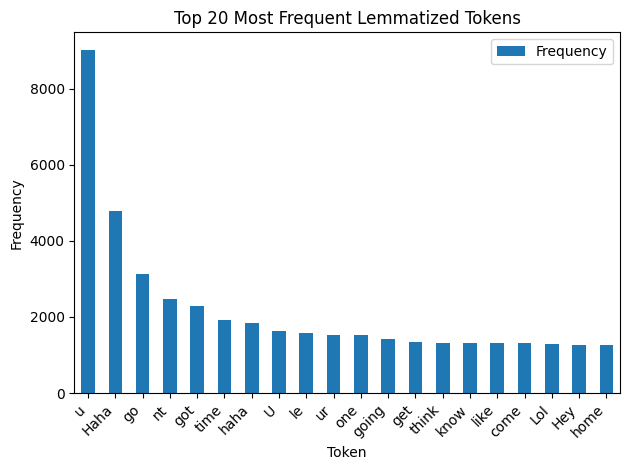

In [55]:
# Create frequency distributions for messaging, sentiments, or key words/phrases

all_tokens = [token for tokens in new_clean_nus_sms['Lemmatized_Tokens'] for token in tokens]

token_frequency = Counter(all_tokens)

token_frequency_df = pd.DataFrame.from_dict(token_frequency, orient='index', columns=['Frequency'])

token_frequency_df = token_frequency_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 6))
token_frequency_df.head(20).plot(kind='bar', title='Top 20 Most Frequent Lemmatized Tokens')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [59]:
# Use POS tagging to find commonly used phrases

# flatten the list
all_tokens = list(itertools.chain.from_iterable(new_clean_nus_sms['Lemmatized_Tokens']))

# join tokens in a list
text = ' '.join(all_tokens)

# tokenize
words = word_tokenize(text)

pos_tags = pos_tag(words)

# determiner, adjective, and noun
grammar = r"""
    NP: {<DT|JJ|NN.*>+} 
"""

parser = RegexpParser(grammar)


parsed_text = parser.parse(pos_tags)

noun_phrases = []
for subtree in parsed_text.subtrees():
    if subtree.label() == 'NP':
        phrase = ' '.join(word for word, tag in subtree.leaves())
        noun_phrases.append(phrase)


noun_phrase_frequency = Counter(noun_phrases)

print("Most common noun phrases:")
for phrase, frequency in noun_phrase_frequency.most_common():
    print(f"{phrase}: {frequency}")

Most common noun phrases:
u: 569
Haha: 435
Hey: 186
U: 166
day: 133
nt: 120
Hahaha: 120
Lol: 112
Oh: 106
today: 104
home: 102
Ok: 96
Yeah: 92
time: 82
dun: 67
help: 67
haha: 67
le: 57
need: 56
Okay: 56
P: 51
way: 50
bus: 50
much: 48
people: 48
Sorry: 47
thing: 45
wan: 43
eat: 42
DECIMAL: 42
dinner: 41
ok: 39
Ohh: 39
work: 38
house: 38
Ya: 38
Eh: 36
someone: 35
know: 34
something: 34
phone: 34
school: 33
ü: 33
sure: 33
dont: 33
hour: 33
lunch: 32
anything: 32
Yes: 32
Nope: 31
leh: 31
call: 31
good: 31
thanks: 30
min: 30
Please: 30
lol: 30
ur: 29
u wan: 29
week: 29
lah: 29
Thanks: 29
friend: 29
money: 29
sch: 28
stuff: 28
free: 28
gon: 28
let: 28
lor: 27
feel: 27
many: 26
Let: 26
wat: 25
ah: 25
sorry: 25
Hi: 25
year: 25
LOL: 25
la: 24
Hmm: 24
hey: 24
Yo: 24
Im: 24
Yup: 23
tmr: 23
guy: 23
meet: 23
Dont: 23
sleep: 23
see: 23
n: 22
mum: 22
Anyway: 22
care: 22
wait: 22
book: 21
co: 21
online: 21
tonight: 21
pm: 21
first: 21
food: 21
fine: 21
Ooo: 21
plan: 20
early: 20
lot: 20
bathe: 20
coz: 

In [73]:
# Naive Bayes classification Model

# first assign a new target column to dataframe
new_clean_nus_sms['target_country'] = clean_nus_sms_copy['country']
X = [' '.join(tokens) for tokens in new_clean_nus_sms['Lemmatized_Tokens']]
y = new_clean_nus_sms['target_country']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)


MultinomialNB()

In [74]:
# predict on test data
y_pred = nb_classifier.predict(X_test_vectorized)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6470164609053498
